# Linear Model MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This additional notebook provides an example of how to use the NumPyro probabilistic programming library to perform an equivalent Bayesian linear regression to `03-Linear-Model.ipynb`. The use of the NumPyro library allows MCMC sampling via the state-of-the-art No-U-Turn Sampler (NUTS).

Note: this notebook requires the installation of the NumPyro library e.g., via
`pip install numpyro`

### Imports

In [1]:
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import numpy as np
import pandas as pd
from ipywidgets import interact, fixed, widgets
# visulisation function
from functions.visualisations import (
    histogram_trace, plot_linear_data,
    plot_y_timeseries, boxplot_weights,
    plot_ycorr_scatter
)

from types import MethodType

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt

np.random.seed(2023)

## Define a linear regression model

$y=f\left(x,\theta\right)+e \qquad e \sim N\left(0,\sigma^2\right)$

- Define a model to output y given the input data and model parameters - $y = \beta x + intercept$
- Place priors on the model parameters

In [2]:
def linear_model(X,Y=None):
    '''
    Model description: Linear regression model
    y = X*beta + epsilon
    '''
    # Counts
    n_variables = X.shape[1]
    # prior for beta
    # regression coeficients
    beta = numpyro.sample("beta", dist.Normal(0,10).expand([n_variables]))
    # intercept term
    intercept = numpyro.sample("intercept", dist.Normal(0,10)) 
    # use a slightly easier to manage prior on the error variance
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    # Model
    mu = numpyro.deterministic("mu", jnp.matmul(X,beta)+intercept)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

In [3]:
# Additional error metric
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [4]:
# load the data
name        = "Sunspot"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))

Training data shape: (298, 5)


## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [5]:
## MCMC Settings and Setup
# from the posterior
data_case = 'sunspot' # 'toy' or 'sunspot'
ci = 0.89

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

jnp_X = jnp.array(x_data)
jnp_Y = jnp.array(y_data)
jnp_X_test = jnp.array(x_test)
jnp_Y_test = jnp.array(y_test)

Sample priors

In [6]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=500)(
    rng_key_, X=jnp_X
)

Sample posterior

In [7]:
# settings 
num_samples = 1000
num_warmup = 1000
num_chains = 4
max_tree = 10
save_bool = False # save to arviz netcdf
load_bool = False # load previous runs from arviz netcdf
extract_vars = ['beta','intercept','mu','sigma','obs'] # variables to extract from posterior_predictive
check_vars = [_ for _ in extract_vars if _ not in ['mu','obs']]

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# now define the sampler - No U-Turn Sampler (NUTS) and run the sampler for num_samples+burnin
nuts = NUTS(linear_model,max_tree_depth=max_tree)
mcmc_obj = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_obj.run(
    rng_key_,
    X = jnp_X,
    Y = jnp_Y
)

# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(
    linear_model, posterior_samples={k:v for k,v in samples.items() if k in check_vars}, 
    return_sites=extract_vars
)(rng_key_, X = jnp_X_test)

# get named arvix object
az_coords = {
    "beta": ["X{}".format(_) for _ in range(jnp_X.shape[1])],
}
# create an arviz object
arviz_posterior = az.from_numpyro(
    mcmc_obj,
    posterior_predictive=posterior_predictive,
    prior = prior_samples,
    coords = az_coords
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
# gather the predicitons into useful variables
stacked_preds = arviz_posterior.stack(sample=("chain", "draw"))
pred_y = stacked_preds.posterior.transpose("sample",...)['mu'].values
pred_y_test = stacked_preds.posterior_predictive.transpose("sample",...)['mu'].values

## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

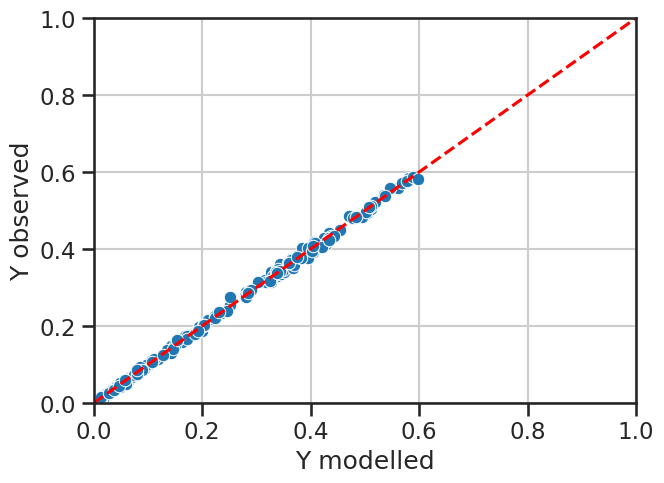

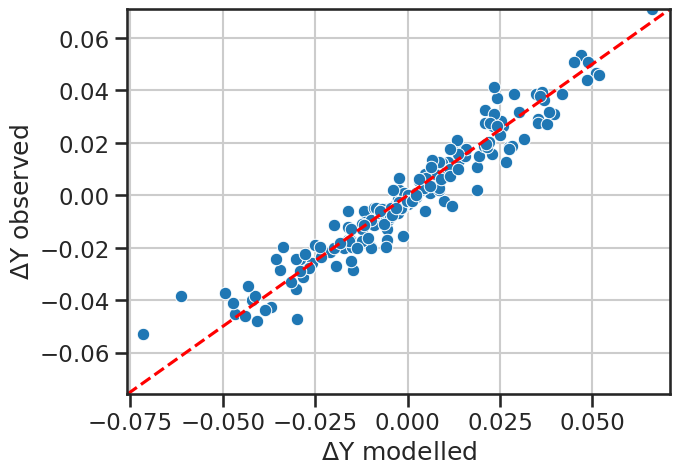

In [9]:
# plot the data with the model predictions from posterior draws
plot_ycorr_scatter(
    y_test,
    pred_y_test
)
plot_ycorr_scatter(
    np.diff(y_test),
    pred_y_test[:,1:] - y_test[:-1],
    minmax=None,
    dy=True
)

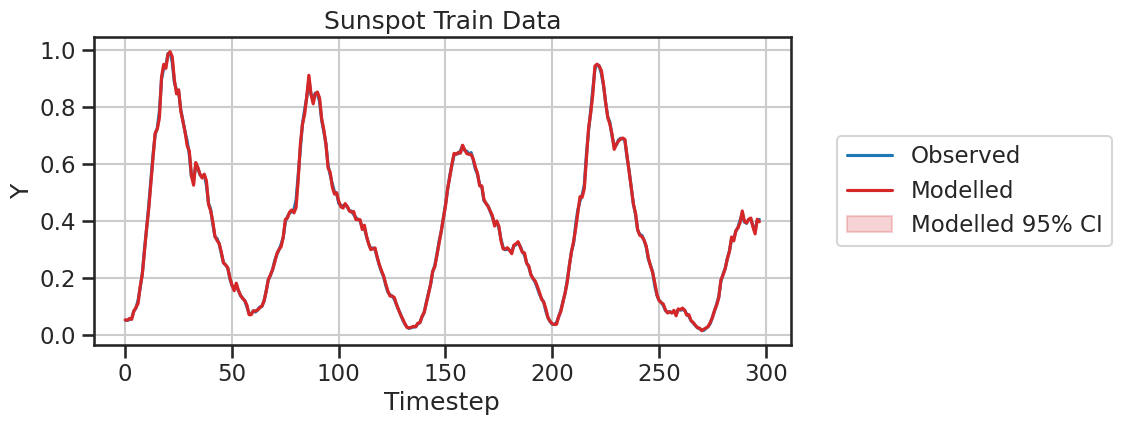

In [10]:
plot_y_timeseries(
    y_data,
    pred_y,
    dataset_name=name + ' Train',
    ci=True
)

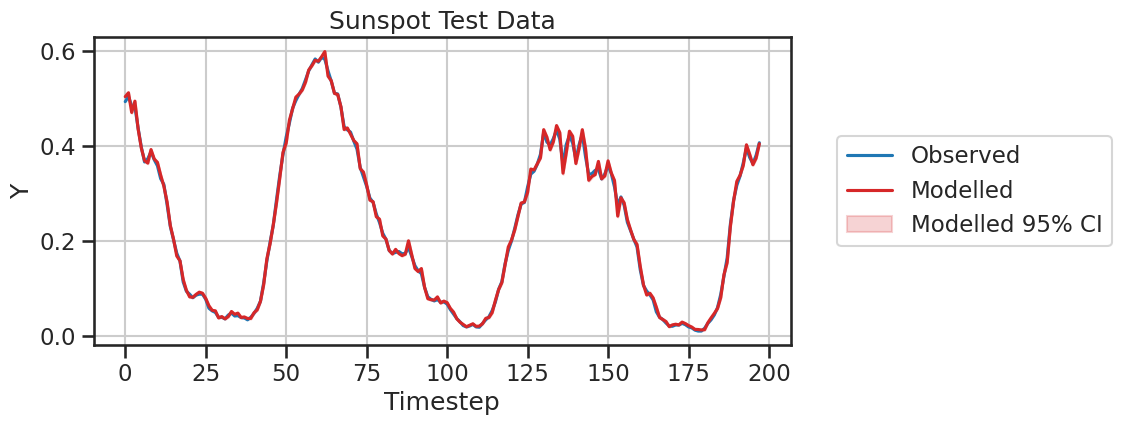

In [11]:
plot_y_timeseries(
    y_test,
    pred_y_test,
    dataset_name=name + ' Test',
    ci=True
)

In [12]:
# Print the train/test RMSE
trainRMSE = np.array([rmse(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testRMSE = np.array([rmse(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train RMSE: {:.5f} ({:.5f})'.format(trainRMSE.mean(),trainRMSE.std()))
print('Test RMSE: {:.5f} ({:.5f})'.format(testRMSE.mean(),testRMSE.std()))

Train RMSE: 0.00651 (0.00004)
Test RMSE: 0.00627 (0.00008)


## MCMC diagnostics and parameter posterior distributions
Display the convergence diagnostics and plot the posterior distributions/traces for each parameter.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.386,0.051,-0.478,-0.284,0.002,0.001,1078.0,1289.0,1.0
beta[1],1.168,0.121,0.933,1.388,0.004,0.003,937.0,1428.0,1.0
beta[2],-2.074,0.119,-2.299,-1.847,0.004,0.003,1048.0,1214.0,1.0
beta[3],2.289,0.050,2.194,2.382,0.001,0.001,1321.0,1469.0,1.0
intercept,0.002,0.001,0.000,0.003,0.000,0.000,3887.0,2585.0,1.0
sigma,0.007,0.000,0.006,0.007,0.000,0.000,1879.0,1641.0,1.0


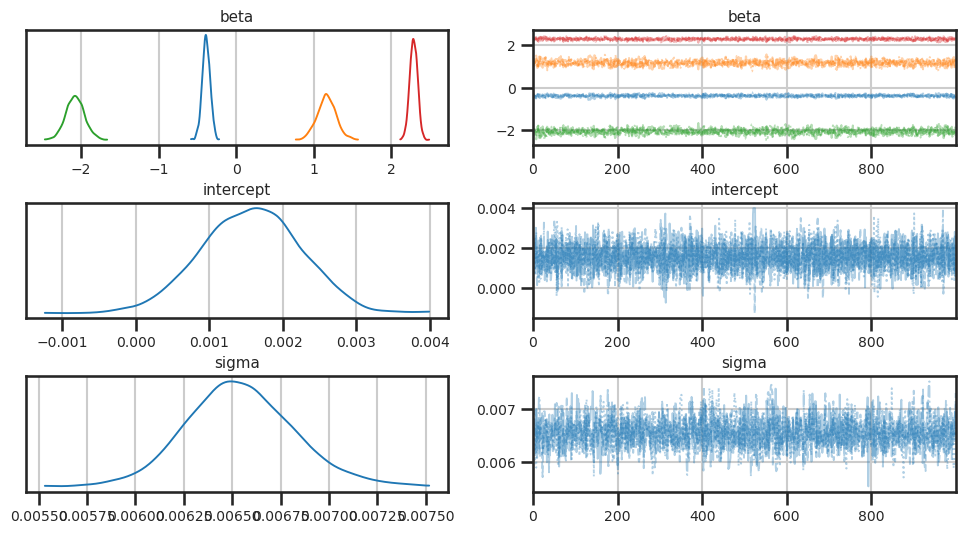

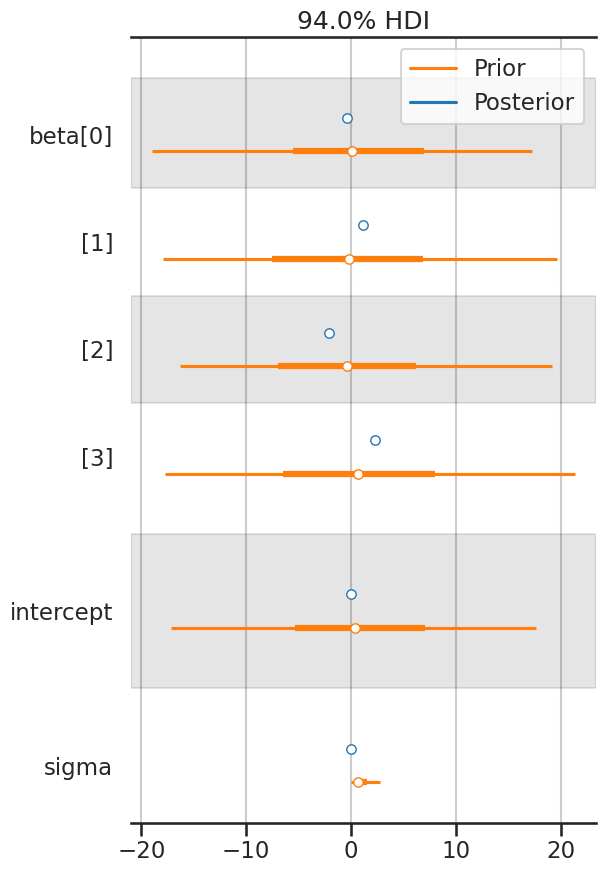

In [13]:
az.plot_trace(arviz_posterior, var_names=check_vars, combined=True)
plt.subplots_adjust(hspace=0.5)
az.plot_forest([arviz_posterior.posterior, arviz_posterior.prior],  model_names=['Posterior','Prior'],var_names=check_vars, combined=True)
az.summary(arviz_posterior, var_names=check_vars)

Prior plotting check

################################################################################
Priors


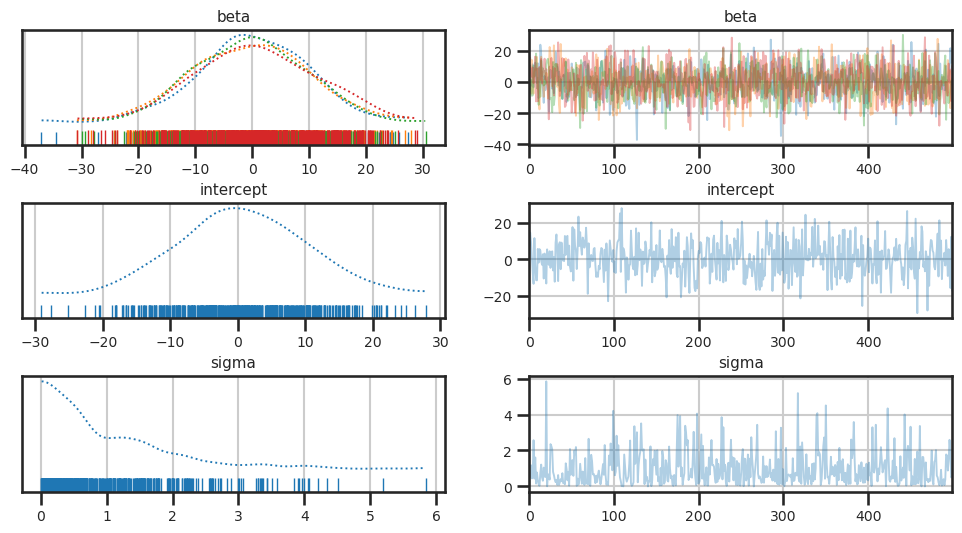

In [14]:
# and now plot the priors to check
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_posterior.prior, 
    var_names=check_vars,
    rug=True,
    combined=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()